# Cuaderno de presentación prueba NLP Davivienda

En este cuaderno se hace una breve descripción de aspectos relevantes obtenidos en los tweets.

In [212]:
#!pip install spacy
#!python -m spacy download es_core_news_sm
#!pip install transformers
#!pip install tensorflow
#!pip install bs4
#!pip install networkx
#!pip install gensim
#!pip install pyLDAvis

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import plotly.express as px
import plotly.graph_objects as go

import spacy
import es_core_news_sm
nlp=spacy.load("es_core_news_sm")
from spacy import displacy

import gensim 
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Phrases
from gensim.models import LdaSeqModel
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation


import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

import urllib
from bs4 import BeautifulSoup

import transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig


import networkx as nx
from networkx.algorithms import community




/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning:

the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses



In [4]:
## Lectura de datos

df_tweets = pd.read_csv("../Datos/davivienda_tweets.csv")
df_tweets.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [123]:
## Limpieza de datos
## Iniciamos extrayendo caracteres especiales (\n)

df_tweets['Embedded_text_1'] = df_tweets['Embedded_text'].apply(lambda x: re.sub(r'\n[ 0-9]*', ' ', x))

## Luego extraemos los links
df_tweets['links'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'http\S+', x))
links_title=[]
for i in df_tweets['links']:
    if len(i)==0:
        links_title.append("")
    else:
        lista_i=[]
        for k in i:
            #print(k)
            try:
                html_page = urllib.request.urlopen(k)
                soup = BeautifulSoup(html_page)
                lista_i.append(soup.title.string)
            except:
               new_k=k.replace("https://","")
               new_k=new_k.replace("http://","")
               new_k=re.sub(r'\.[A-Za-z\.]*', '', new_k)
               new_k=re.sub(r'\/.*', '', new_k)
               lista_i.append(new_k)
        links_title.append(lista_i)

df_tweets['links_title']=links_title
df_tweets['conteo_links'] = df_tweets['links'].apply(lambda x: len(x))
df_tweets['Embedded_text_1'] = df_tweets['Embedded_text_1'].apply(lambda x: re.sub(r'http\S+', 'Link_aqui', x))

## Luego extraemos los hashtags
df_tweets['hashtags'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'#\S+', x))
df_tweets['conteo_hashtags'] = df_tweets['hashtags'].apply(lambda x: len(x))

## Luego extraemos los menciones
df_tweets['menciones'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'@\S+', x))
df_tweets['menciones'] = [[re.sub("[^0-9A-Za-z\_\-@]","",men.lower()) for men in k] for k in df_tweets['menciones']]
df_tweets['conteo_menciones'] = df_tweets['menciones'].apply(lambda x: len(x))

df_tweets['UserName']=df_tweets['UserName'].apply(lambda x: re.sub("[^0-9A-Za-z\_\-@]","",x.lower()))


In [43]:
## Luego extraemos los emojis
df_tweets['emojis'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'\\u\S+', x))
df_tweets['conteo_emojis'] = df_tweets['emojis'].apply(lambda x: len(x))

## Luego extraemos los RT
df_tweets['RT'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'RT', x))
df_tweets['conteo_RT'] = df_tweets['RT'].apply(lambda x: len(x))



In [44]:
## Análisis de sentimientos

## Cargamos el modelo de sentimientos

from transformers import pipeline
nlp_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

## Aplicamos el modelo a los tweets

df_tweets['sentiment'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['label'])
df_tweets['sentiment_score'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['sentiment_score'])


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [45]:
df_tweets['sentiment'].value_counts()

1 star     1250
5 stars     314
4 stars     152
3 stars      51
2 stars      44
Name: sentiment, dtype: int64

In [46]:
df_tweets['sentiment_score'].describe()

count    1811.000000
mean        0.546778
std         0.188656
min         0.219787
25%         0.389547
50%         0.513138
75%         0.697739
max         0.971901
Name: score, dtype: float64

In [50]:
df_tweets['menciones']

0                               []
1                               []
2                    [@davivienda]
3       [@davivienda, @davivienda]
4                    [@davivienda]
                   ...            
1806                [@jaimemolina]
1807                   [@josefe71]
1808                  [@gleniiaaa]
1809                  [@diegoruix]
1810                  [@diegoruix]
Name: menciones, Length: 1811, dtype: object

In [124]:
## Creamos redes para identificar relaciones entre usuarios. Em pezamos por la mención de usuarios.
list_df=[]
for i in range(len(df_tweets)):
    for j in df_tweets['menciones'][i]:
            df_edges_mencion_temp=pd.DataFrame(data={'Source':[df_tweets['UserName'][i]],'Target':[j],'Weight':[1],'Type':['Mencion']})
            list_df.append(df_edges_mencion_temp)
df_edges_mencion=pd.concat(list_df)
df_edges_mencion=df_edges_mencion.groupby(['Source','Target','Type']).sum().reset_index()



In [125]:
df_edges_mencion

,Source,Target,Type,Weight
0,@04elisabeth,@asnasalvaje,Mencion,1
1,@04elisabeth,@davivienda,Mencion,5
2,@04elisabeth,@sfcsupervisor,Mencion,1
3,@04elisabeth,@sicsuper,Mencion,1
4,@04elisabeth,@wilsonariasc,Mencion,1
...,...,...,...,...
2376,h@ner,@bancolombia,Mencion,1
2377,h@ner,@davivienda,Mencion,1
2378,karen-aleja-287@hotmailcom,@davivienda,Mencion,1
2379,profedellanterawilburbloqueadopor@ca_acosta,@fervarelahn,Mencion,1


In [126]:
## Seguimos por la co ocurrencia en tweets
df_edges_relacion=pd.DataFrame(columns=['Source','Target','Weight','Type'])
list_source=[]
list_target=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        n=len(i)
        for k in range(n-1):
            for j in range(k+1,n):
                if i[k]!=i[j]:
                    list_source.append(i[k])
                    list_target.append(i[j])
                    list_weight.append(1)
                    list_type.append("undirected")
df_edges_relacion['Source']=list_source
df_edges_relacion['Target']=list_target
df_edges_relacion['Weight']=list_weight
df_edges_relacion['Type']=list_type
df_edges_relacion=df_edges_relacion.groupby(['Source','Target','Type']).sum().reset_index()

df_edges_relacion.to_csv("../Datos/relacion_menciones.csv",index=False)

df_users_menciones=pd.DataFrame(columns=['Id','Label','Weight','Type'])
list_id=[]
list_label=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        for k in i:
            list_id.append(k)
            list_label.append(k)
            list_weight.append(1)
            list_type.append("Undirected")
df_users_menciones['Id']=list_id
df_users_menciones['Label']=list_label
df_users_menciones['Weight']=list_weight
df_users_menciones['Type']=list_type
df_users_menciones=df_users_menciones.groupby(['Id','Label','Type']).sum().reset_index()

df_users_menciones.to_csv("../Datos/usuarios_menciones.csv",index=False)



In [127]:
## Veamos las relaciones de usuarios en mapas de calor

df_heat_map=df_edges_mencion.groupby(['Source','Target']).sum().reset_index()
df_heat_map=df_heat_map.pivot(index='Source',columns='Target',values='Weight')
df_heat_map=df_heat_map.fillna(0)



/tmp/ipykernel_37159/1964696390.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [165]:
df_heat_map[((df_heat_map>0).sum()[(df_heat_map>0).sum()>3]).index]

Target,@an4cr0s,@andrescepeda,@asnasalvaje,@augustoocampo,@banco_avvillas,@bancodebogota,@bancolombia,@bancosaval,@bbva,@binance,...,@petrogustavo,@prosperidadcol,@scotiacolpatria,@segurosbolivar,@sfcsupervisor,@sicsuper,@ssf_elsalvador,@susanacorreabor,@telefonorojo,@wilsonariasc
Source,,,,,,,,,,,,,,,,,,,,,
@04elisabeth,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
@andresoso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@berzota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
@cnoguera20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
@davicorredores,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
@edimejia1979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@eljulisoquete,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
@enriquedelgadop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
@fabiofernandoh1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


(35, 53)


<AxesSubplot: xlabel='Target', ylabel='Source'>

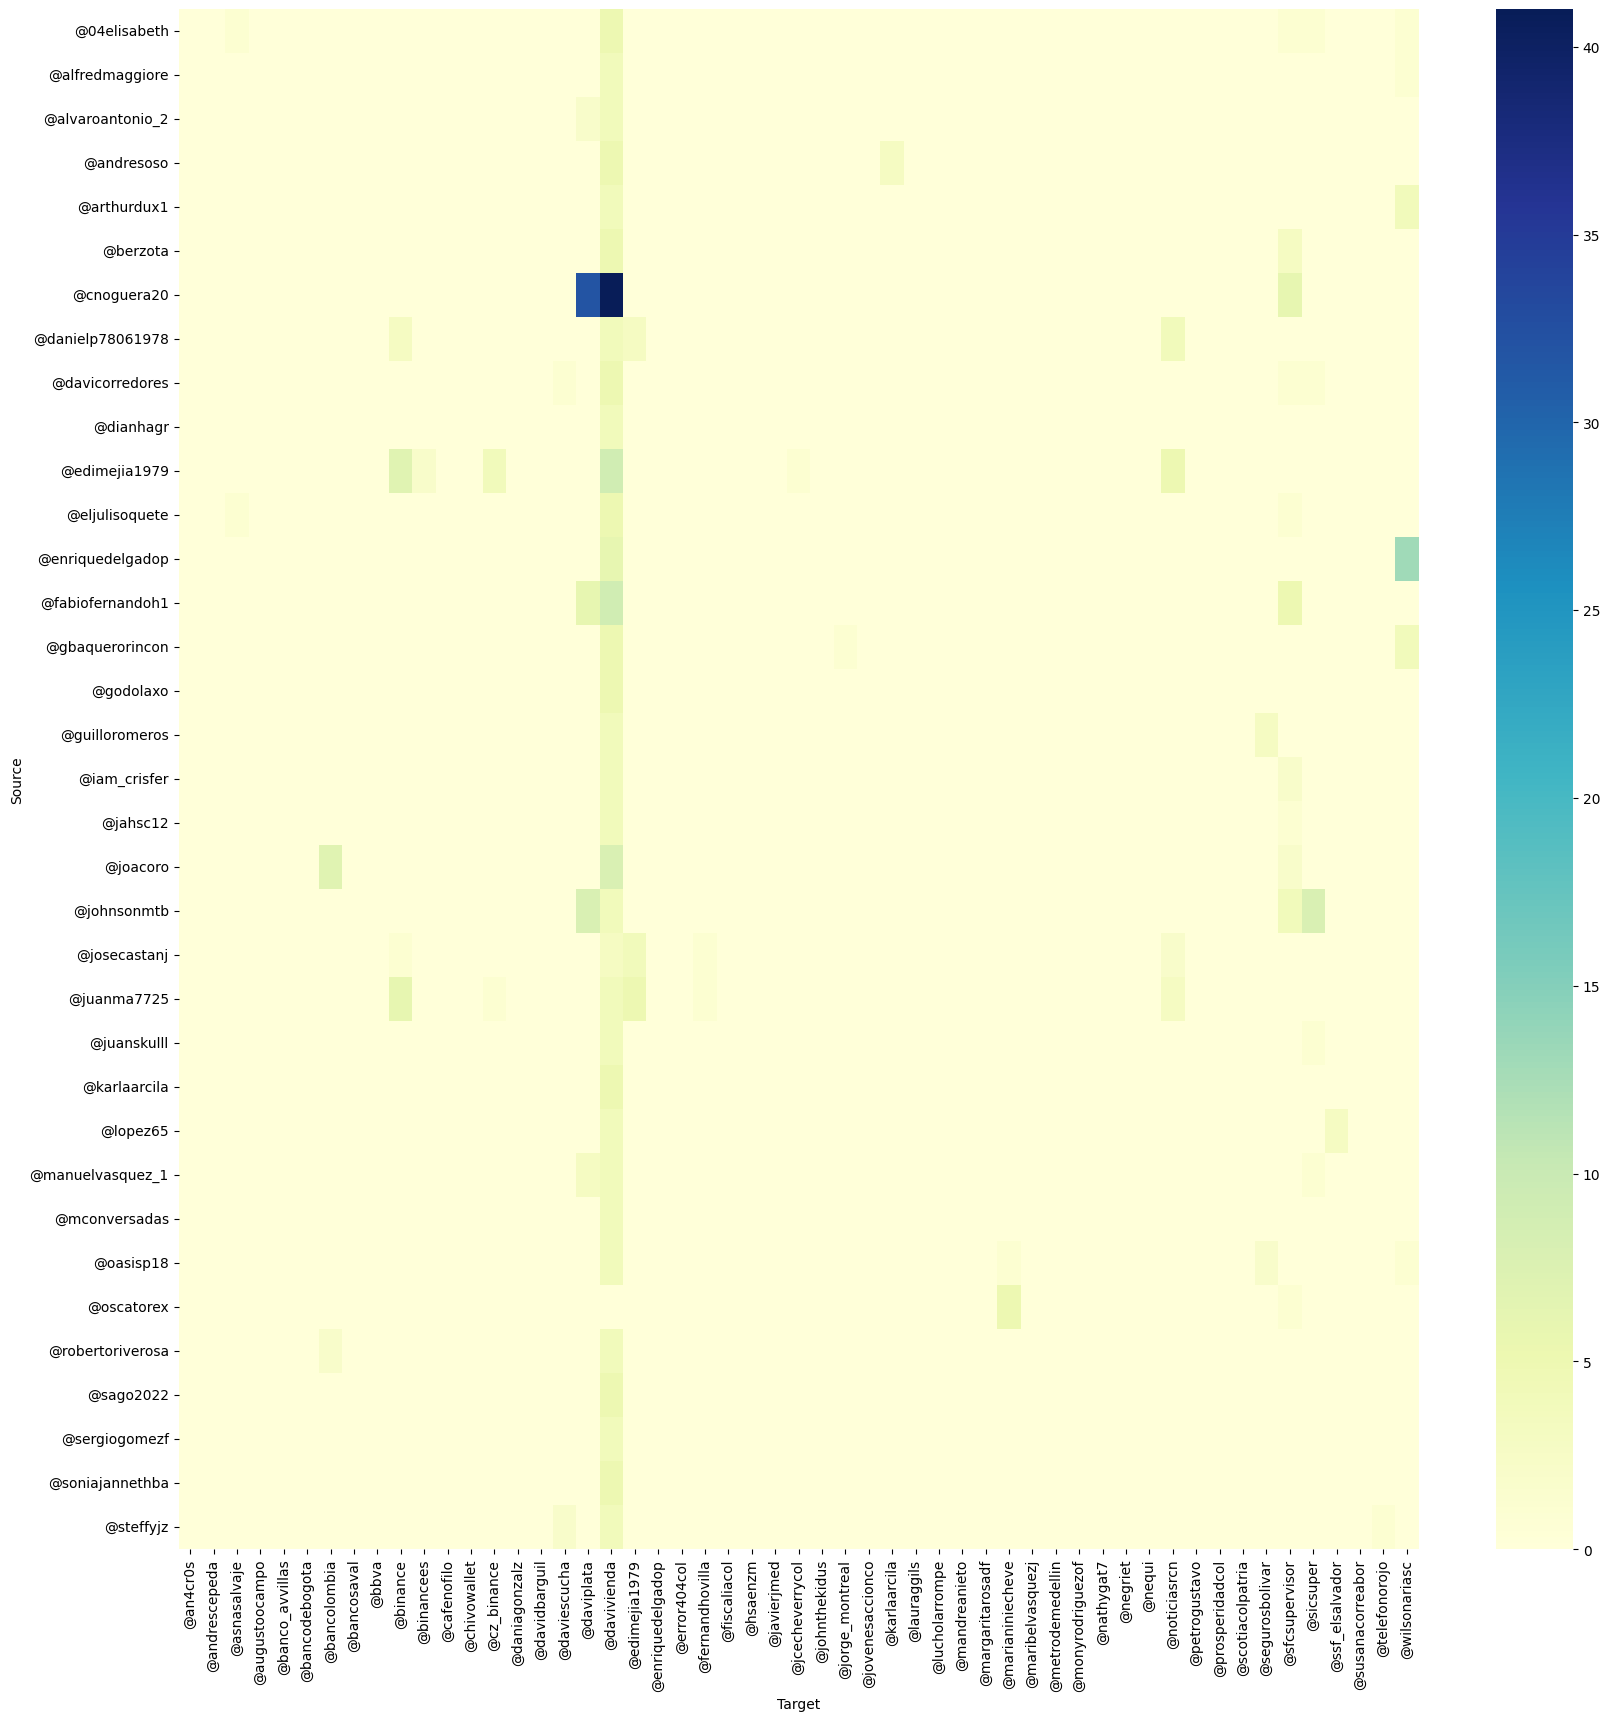

In [177]:
df_columns_heatmap=df_heat_map[((df_heat_map>0).sum()[(df_heat_map>0).sum()>3]).index]
df_columns_heatmap=df_columns_heatmap[((df_columns_heatmap>3).sum(axis=1)>0)]
print(df_columns_heatmap.shape)

plt.figure(figsize=(20,20))
sns.heatmap(df_columns_heatmap,cmap="YlGnBu")


In [178]:
df_1=df_edges_mencion[df_edges_mencion['Source'].isin(df_columns_heatmap.index)]
df_1=df_1[df_1['Target'].isin(df_columns_heatmap.columns)]
df_1

,Source,Target,Type,Weight
0,@04elisabeth,@asnasalvaje,Mencion,1
1,@04elisabeth,@davivienda,Mencion,5
2,@04elisabeth,@sfcsupervisor,Mencion,1
3,@04elisabeth,@sicsuper,Mencion,1
4,@04elisabeth,@wilsonariasc,Mencion,1
...,...,...,...,...
2170,@sergiogomezf,@davivienda,Mencion,4
2200,@soniajannethba,@davivienda,Mencion,5
2231,@steffyjz,@daviescucha,Mencion,2
2232,@steffyjz,@davivienda,Mencion,4


In [179]:
labels_df1=enumerate(list(set(list(df_1.Source)+list(df_1.Target))))
labels_df1=dict((y,x) for x,y in labels_df1)

df_1['Source_num']=df_1['Source'].apply(lambda x: labels_df1[x])
df_1['Target_num']=df_1['Target'].apply(lambda x: labels_df1[x])

In [180]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(set(list(df_1.Source)+list(df_1.Target)))
    ),
    link = dict(
      source = df_1['Source_num'], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_1['Target_num'],
      value = df_1['Weight']
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [68]:
## Veamos las relaciones de usuarios agrupando y ordenando por cantidad de menciones

df_agrupacion_fuente=df_edges_mencion.groupby(['Source']).agg({'Target':'count','Weight':'sum'}).reset_index()
df_agrupacion_fuente.sort_values(by=['Target'],ascending=False,inplace=True)
df_agrupacion_fuente.head(20)

,Source,Target,Weight
142,@Davivienda,208,248
334,@Juanma7725,11,27
1000,@santini_es,10,10
686,@davicorredores,10,22
244,@Guilloromeros,9,22
811,@johnsonmtb,8,40
128,@DamarisMarino,8,8
171,@Edimejia1979,8,32
844,@julioorozco29,7,10
194,@EnriqueDelgadoP,7,24


In [70]:
df_agrupacion_mencionados=df_edges_mencion.groupby(['Target']).agg({'Source':'count','Weight':'sum'}).reset_index()
df_agrupacion_mencionados.sort_values(by=['Source'],ascending=False,inplace=True)
df_agrupacion_mencionados.head(20)

,Target,Source,Weight
212,@davivienda,746,1103
832,@wilsonariasc,80,106
752,@sfcsupervisor,63,88
211,@daviplata,57,121
554,@marianiniecheve,53,60
71,@asnasalvaje,45,47
93,@bancolombia,44,54
744,@segurosbolivar,32,39
756,@sicsuper,20,27
473,@karlaarcila,20,25


In [201]:
user_relaciones=df_users_menciones[df_users_menciones['Weight']>3]
edges_relaciones=df_edges_relacion[df_edges_relacion['Weight']>3]


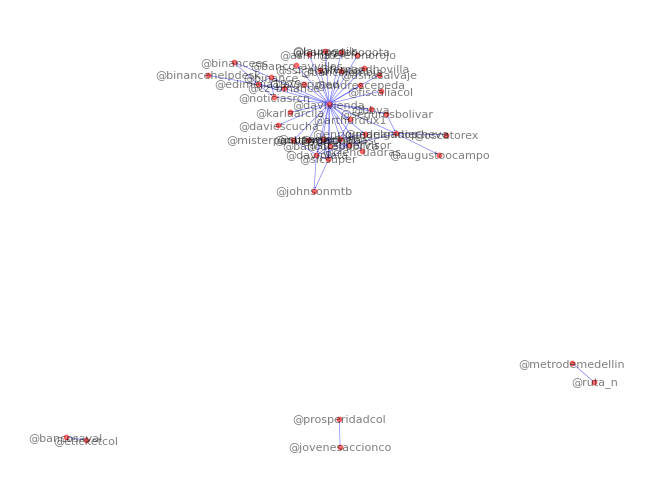

In [204]:
### Pintamos las redes

#nodes=user_relaciones[['Id','Label']]
edges=edges_relaciones[['Source','Target','Weight']]
G=nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=True, create_using=nx.Graph())
#G.add_nodes_from(nodes['Id'].values)
nx.draw(G, with_labels=True, node_size=10, font_size=8, node_color='red', edge_color='blue', width=0.5, alpha=0.5, arrowsize=1, arrowstyle='->', arrows=True)



In [205]:
## Guardamos la información lograda hasta ahora
df_tweets.to_csv("../Datos/tweets_procesados.csv",index=False)
df_users_menciones.to_csv("../Datos/usuarios_menciones.csv",index=False)
df_edges_mencion.to_csv("../Datos/relacion_menciones.csv",index=False)
df_edges_relacion.to_csv("../Datos/relacion_mencionados.csv",index=False)



In [235]:
## Hacemos un análisis de temas utilizando topic modeling
## Preparamos los datos para el análisis de temas

### Eliminamos los tweets que no tienen texto

df_tweets_2=df_tweets.copy()
df_tweets_2=df_tweets_2[df_tweets_2['Embedded_text'].notnull()]
df_tweets_2=df_tweets_2[df_tweets_2['Embedded_text']!='']

### procesamos el texto

df_tweets_2['processed_text']=df_tweets_2['Embedded_text'].apply(lambda x: x.lower())
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: re.sub(r'[^a-z0-9áéíóúñü@# ]', '', x))
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: re.sub(r' +', ' ', x))
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: x.strip())

stopwords_es = nltk.corpus.stopwords.words('spanish')

In [224]:
def tokenize(text: str) -> str:
    """Tokenize given text"""
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation]
    text = preprocess_string(text, CUSTOM_FILTERS)

    return text


In [225]:
nlp_spacy=spacy.load('es_core_news_sm')
def lemmatize_spacy(text: str) -> str:
    """Lemmatize given text"""
    return " ".join([token.lemma_ for token in nlp_spacy(text)])

doc_lemma = [lemmatize_spacy(doc) for doc in df_tweets_2['processed_text'].values]
doc_tokens = [tokenize(doc) for doc in doc_lemma]
bigram = gensim.models.Phrases(doc_tokens, threshold=100, min_count=5)
doc_bigram = [bigram[doc_tokens[i]] for i in range(len(doc_tokens))]

In [233]:
for x in doc_bigram[0]:
    print(x)

el
confianza
él
afectar
el
indicador
de
confianza
davivienda
tener
uno
leve
caída
en
noviembre
romper
uno
tendencia
de
cinco
mes
de
mejora
el
indicador
él
deteriorar
especialmente
en
el
último
semana
del
mes
asociado
al
aumento
en
el
tasa
de
cambio1719


In [239]:
doc_list=[]
for sent in doc_bigram:
    new_doc = [str(word) for word in sent if word not in stopwords_es and len(word)>3]
    doc_list.append(new_doc)
df_tweets_2['processed_text']=doc_list

### Creamos el diccionario y el corpus

dictionary = corpora.Dictionary(df_tweets_2['processed_text'].values)
corpus = [dictionary.doc2bow(text) for text in df_tweets_2['processed_text'].values]


In [251]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [252]:
### amplicamos el modelo

best_num=0
best_coherence=0

for i in range(2,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=i,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    coherence_model=CoherenceModel(model=lda_model, texts=df_tweets_2['processed_text'].values, dictionary=dictionary, coherence='c_v')
    coherence=coherence_model.get_coherence()
    print("Coherence score for {} topics: {}".format(i, coherence))

    if coherence>best_coherence:
        print("grupos {} y coherencia: {}".format(i,coherence))
        best_num =i
        best_coherence=coherence

print("El mejor puntaje de coherence es {} para {} temas".format(best_coherence,best_num))




Coherence score for 2 topics: 0.5109197310138296
grupos 2 y coherencia: 0.5109197310138296
Coherence score for 3 topics: 0.5165521422669112
grupos 3 y coherencia: 0.5165521422669112
Coherence score for 4 topics: 0.5199353436102598
grupos 4 y coherencia: 0.5199353436102598
Coherence score for 5 topics: 0.47985086404616134
Coherence score for 6 topics: 0.45559158899934604
Coherence score for 7 topics: 0.4929380739112959
Coherence score for 8 topics: 0.5055075162340867
Coherence score for 9 topics: 0.4995579929499534
El mejor puntaje de coherence es 0.5199353436102598 para 4 temas


In [271]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=best_num,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

for topic in lda_model.print_topics():
    print(topic)


(0, '0.044*"respuesta" + 0.022*"wilsonariasc" + 0.015*"davivienda" + 0.010*"daviviendir" + 0.007*"banco" + 0.007*"lugar_equivocado" + 0.006*"hablar" + 0.005*"daviviendano" + 0.005*"lugar" + 0.004*"empresa"')
(1, '0.040*"davivienda" + 0.037*"respuesta" + 0.022*"hacer" + 0.021*"tener" + 0.018*"haber" + 0.016*"cuenta" + 0.012*"poder" + 0.012*"banco" + 0.012*"daviviendo" + 0.011*"daviplata"')
(2, '0.059*"respuesta" + 0.057*"mensaje" + 0.043*"privado" + 0.040*"caso" + 0.022*"ayudar" + 0.020*"quedar_atento" + 0.020*"validar" + 0.018*"tarde" + 0.018*"detalle" + 0.015*"gusto"')
(3, '0.031*"responder" + 0.007*"navidad" + 0.007*"mencionar" + 0.007*"llegar" + 0.006*"cobrar" + 0.004*"bien" + 0.004*"daviviendir" + 0.004*"daviviendo" + 0.004*"comercial" + 0.004*"prueba"')


In [286]:
topic_dist = lda_model[corpus]

# Agregar distribución de temas a los datos
df_tweets_2['Distribución de temas'] = [x for x in topic_dist]


# Identificar el tema más probable para cada tweet
Lista_temas=[]
for i in df_tweets_2['Distribución de temas']:
    df_temp=pd.DataFrame(i[0])
    df_temp.columns=['Tema','Probabilidad']
    df_temp.sort_values(by='Probabilidad',ascending=False,inplace=True)
    Lista_temas.append(df_temp.iloc[0,0])
df_tweets_2['Tema más probable']=Lista_temas

# Guardar los datos
df_tweets_2.to_csv("../Datos/tweets_procesados_temas.csv",index=False)

df_tweets_2['Tema más probable'].value_counts()

1    947
0    316
2    304
3    244
Name: Tema más probable, dtype: int64

In [255]:
# visualize LDA model results
pyLDAvis.enable_notebook()
gensim_models.prepare(lda_model, dictionary=dictionary, corpus=corpus)

/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.120862  0.214129       1        1  50.605828
2      0.318844  0.009030       2        1  20.351592
3     -0.107974 -0.162254       3        1  14.574322
0     -0.090008 -0.060905       4        1  14.468259, topic_info=            Term        Freq       Total Category  logprob  loglift
333      mensaje  294.000000  294.000000  Default  30.0000  30.0000
178    respuesta  944.000000  944.000000  Default  29.0000  29.0000
708      privado  221.000000  221.000000  Default  28.0000  28.0000
690         caso  206.000000  206.000000  Default  27.0000  27.0000
7     davivienda  564.000000  564.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
178    respuesta  161.686440  944.348603   Topic4  -3.1235   0.1684
37   daviviendir   35.182990   95.280229   Topic4  -4.6486   0.9370
7     davivienda   54.171472  564.636410   Topic4  -4.2170  -0.4108
23         banco   24.897109  182.269672   Topic4  -4.9944  -0.0575
108      conocer    8.539007   17.167386   Topic4  -6.0645   1.2348

[177 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
3531      2  0.976082  antemano_ofrecer
2224      2  0.438448          anterior
2224      3  0.535880          anterior
2232      3  0.704923              aquí
2232      4  0.271124              aquí
...     ...       ...               ...
900       3  0.951732              vida
2261      1  0.081368             vivir
2261      4  0.895050             vivir
4817      1  0.246836      wilsonariasc
4817      4  0.749649      wilsonariasc

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])